# Detecção de Objetos com YOLOv8

Seguindo na trilha de desafios de projeto, faremos a implementação de um sistema de detecção de objetos utilizando a [***rede YOLOv8 otimizada pela Ultralytics***](https://github.com/ultralytics/ultralytics) que se apoiará num conjunto de dados que consiste em 4.816 imagens com 5.058 objetos rotulados pertencentes a 4 classes diferentes, incluindo garrafa de plástico, garrafa de vidro, lata de alumínio e garrafa de leite de plástico (Trashnet), realizado por [***Arkadiy Serezhkin***](https://www.kaggle.com/datasets/arkadiyhacks/drinking-waste-classification).

A configuração do ambiente será feita tendo como base a [***documentação sobre detecção de objetos da Ultralytics***](https://docs.ultralytics.com/tasks/detect/).

Yolov8 tem muitas vantagens sobre os modelos antigos como a otimização de paramêtros de data augmentation, melhor uso das GPUs, diminuindo assim o tempo total de treinamento e um ambiente que precisa de menos linhas de códigos para fazer o treinamento de um modelo de detecção.

Um treinamento de detecção com 3370 imagens no modelo yolov3 levaria 19 horas no mesmo ambiente colab com a GPU T4, enquanto o modelo Yolov8 leva em torno de 40 minutos.

Primeiro instalamos o pacote ultralytics

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 23.4 MB/s eta 0:00:00


Levando em consideração que baixar o banco de imagens e fazer a manipualação delas dentro do colab seria muito mais trabalhoso, fiz a manipulação das imagens e seus relativos arquivos `.txt` no próprio sistema operacional e fiz o manejo deles com um script que compartilho abaixo.

In [ ]:
'''
#!/bin/bash

# Input directory containing all .jpg and .txt files
input_dir="/path/to/image_folder"

# Output directories
train_images_dir="/path/to/waste-detection/train/images"
train_labels_dir="/path/to/waste-detection/train/labels"
test_images_dir="/path/to/waste-detection/test/images"
test_labels_dir="/path/to/waste-detection/test/labels"
val_images_dir="/path/to/waste-detection/val/images"
val_labels_dir="/path/to/waste-detection/val/labels"

# Create the output directories if they don't exist
mkdir -p "$train_images_dir" "$train_labels_dir"
mkdir -p "$test_images_dir" "$test_labels_dir"
mkdir -p "$val_images_dir" "$val_labels_dir"

# Get all .jpg files from the input directory
jpg_files=("$input_dir"/*.jpg)

# Total number of items
total_items=${#jpg_files[@]}

# Calculate the number of items for each split
train_count=$((total_items * 70 / 100))  # 70% for training
test_count=$((total_items * 15 / 100))   # 15% for testing
val_count=$((total_items - train_count - test_count)) # Remaining 15% for validation

# Shuffle the array of .jpg files
shuffled_files=($(shuf -e "${jpg_files[@]}"))

# Helper function to copy files
copy_files() {
    local start_index=$1
    local end_index=$2
    local images_dir=$3
    local labels_dir=$4

    for ((i = start_index; i < end_index; i++)); do
        jpg_file="${shuffled_files[$i]}"
        txt_file="${jpg_file%.jpg}.txt"  # Replace .jpg with .txt

        # Copy the .jpg file to the images directory
        cp "$jpg_file" "$images_dir/"

        # Copy the .txt file to the labels directory, if it exists
        if [[ -f "$txt_file" ]]; then
            cp "$txt_file" "$labels_dir/"
        fi
    done
}

# Copy files for training set
copy_files 0 "$train_count" "$train_images_dir" "$train_labels_dir"

# Copy files for testing set
copy_files "$train_count" $((train_count + test_count)) "$test_images_dir" "$test_labels_dir"

# Copy files for validation set
copy_files $((train_count + test_count)) "$total_items" "$val_images_dir" "$val_labels_dir"

# Notify the user
echo "Dataset split and files copied successfully!"
echo "Training set: $train_count images"
echo "Testing set: $test_count images"
echo "Validation set: $val_count images"
'''

Após ter a pasta na estrutura:

In [ ]:
'''
/waste-detecton
--/train
----/images
----/labels
--/test
----/images
----/labels
--/val
----/images
----/labels
'''

precisamos criar o arquivo `data.yaml` que fará a configuração necessária para passar os parametros de treinamento para o yolo, que terá a configuração abaixo:

In [ ]:
'''
names:
 - alucan
 - glass
 - plasticmilk
 - pet
nc: 4
test: /content/waste-detection/test/images
train: /content/waste-detection/train/images
val: /content/waste-detection/val/images
'''

Após salvar o arquivo `data.yaml` dentro do diretório `waste-detection`, zipamos o diretório e subimos ele para seu Google Drive.

Após isso fazemos o acesso do nosso Google Drive através do comando abaixo:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/darknet/waste-detection.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: waste-detection/train/images/PET706.jpg  
  inflating: waste-detection/train/images/PET708.jpg  
  inflating: waste-detection/train/images/PET709.jpg  
  inflating: waste-detection/train/images/PET712.jpg  
  inflating: waste-detection/train/images/PET714.jpg  
  inflating: waste-detection/train/images/PET715.jpg  
  inflating: waste-detection/train/images/PET716.jpg  
  inflating: waste-detection/train/images/PET717.jpg  
  inflating: waste-detection/train/images/PET719.jpg  
  inflating: waste-detection/train/images/PET720.jpg  
  inflating: waste-detection/train/images/PET721.jpg  
  inflating: waste-detection/train/images/PET722.jpg  
  inflating: waste-detection/train/images/PET724.jpg  
  inflating: waste-detection/train/images/PET726.jpg  
  inflating: waste-detection/train/images/PET727.jpg  
  inflating: waste-detection/train/images/PET729.jpg  
  inflating: waste-detection/train/images/PET730.jpg  
  infl

Agora apenas rodamos o comando abaixo para começar o treinamento do nosso modelo de detecção

In [7]:
!yolo task=detect mode=train model=yolov8m.pt data=/content/waste-detection/data.yaml epochs=20 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 49.7M/49.7M [00:00<00:00, 319MB/s]
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/waste-detection/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False,

Terminado o treinamento uma pasta `run/detect/train` será criada onde vários parametros do treinamento já foram gerados automaticamente, como a Matriz de Confusão de desempenho do nosso modelo

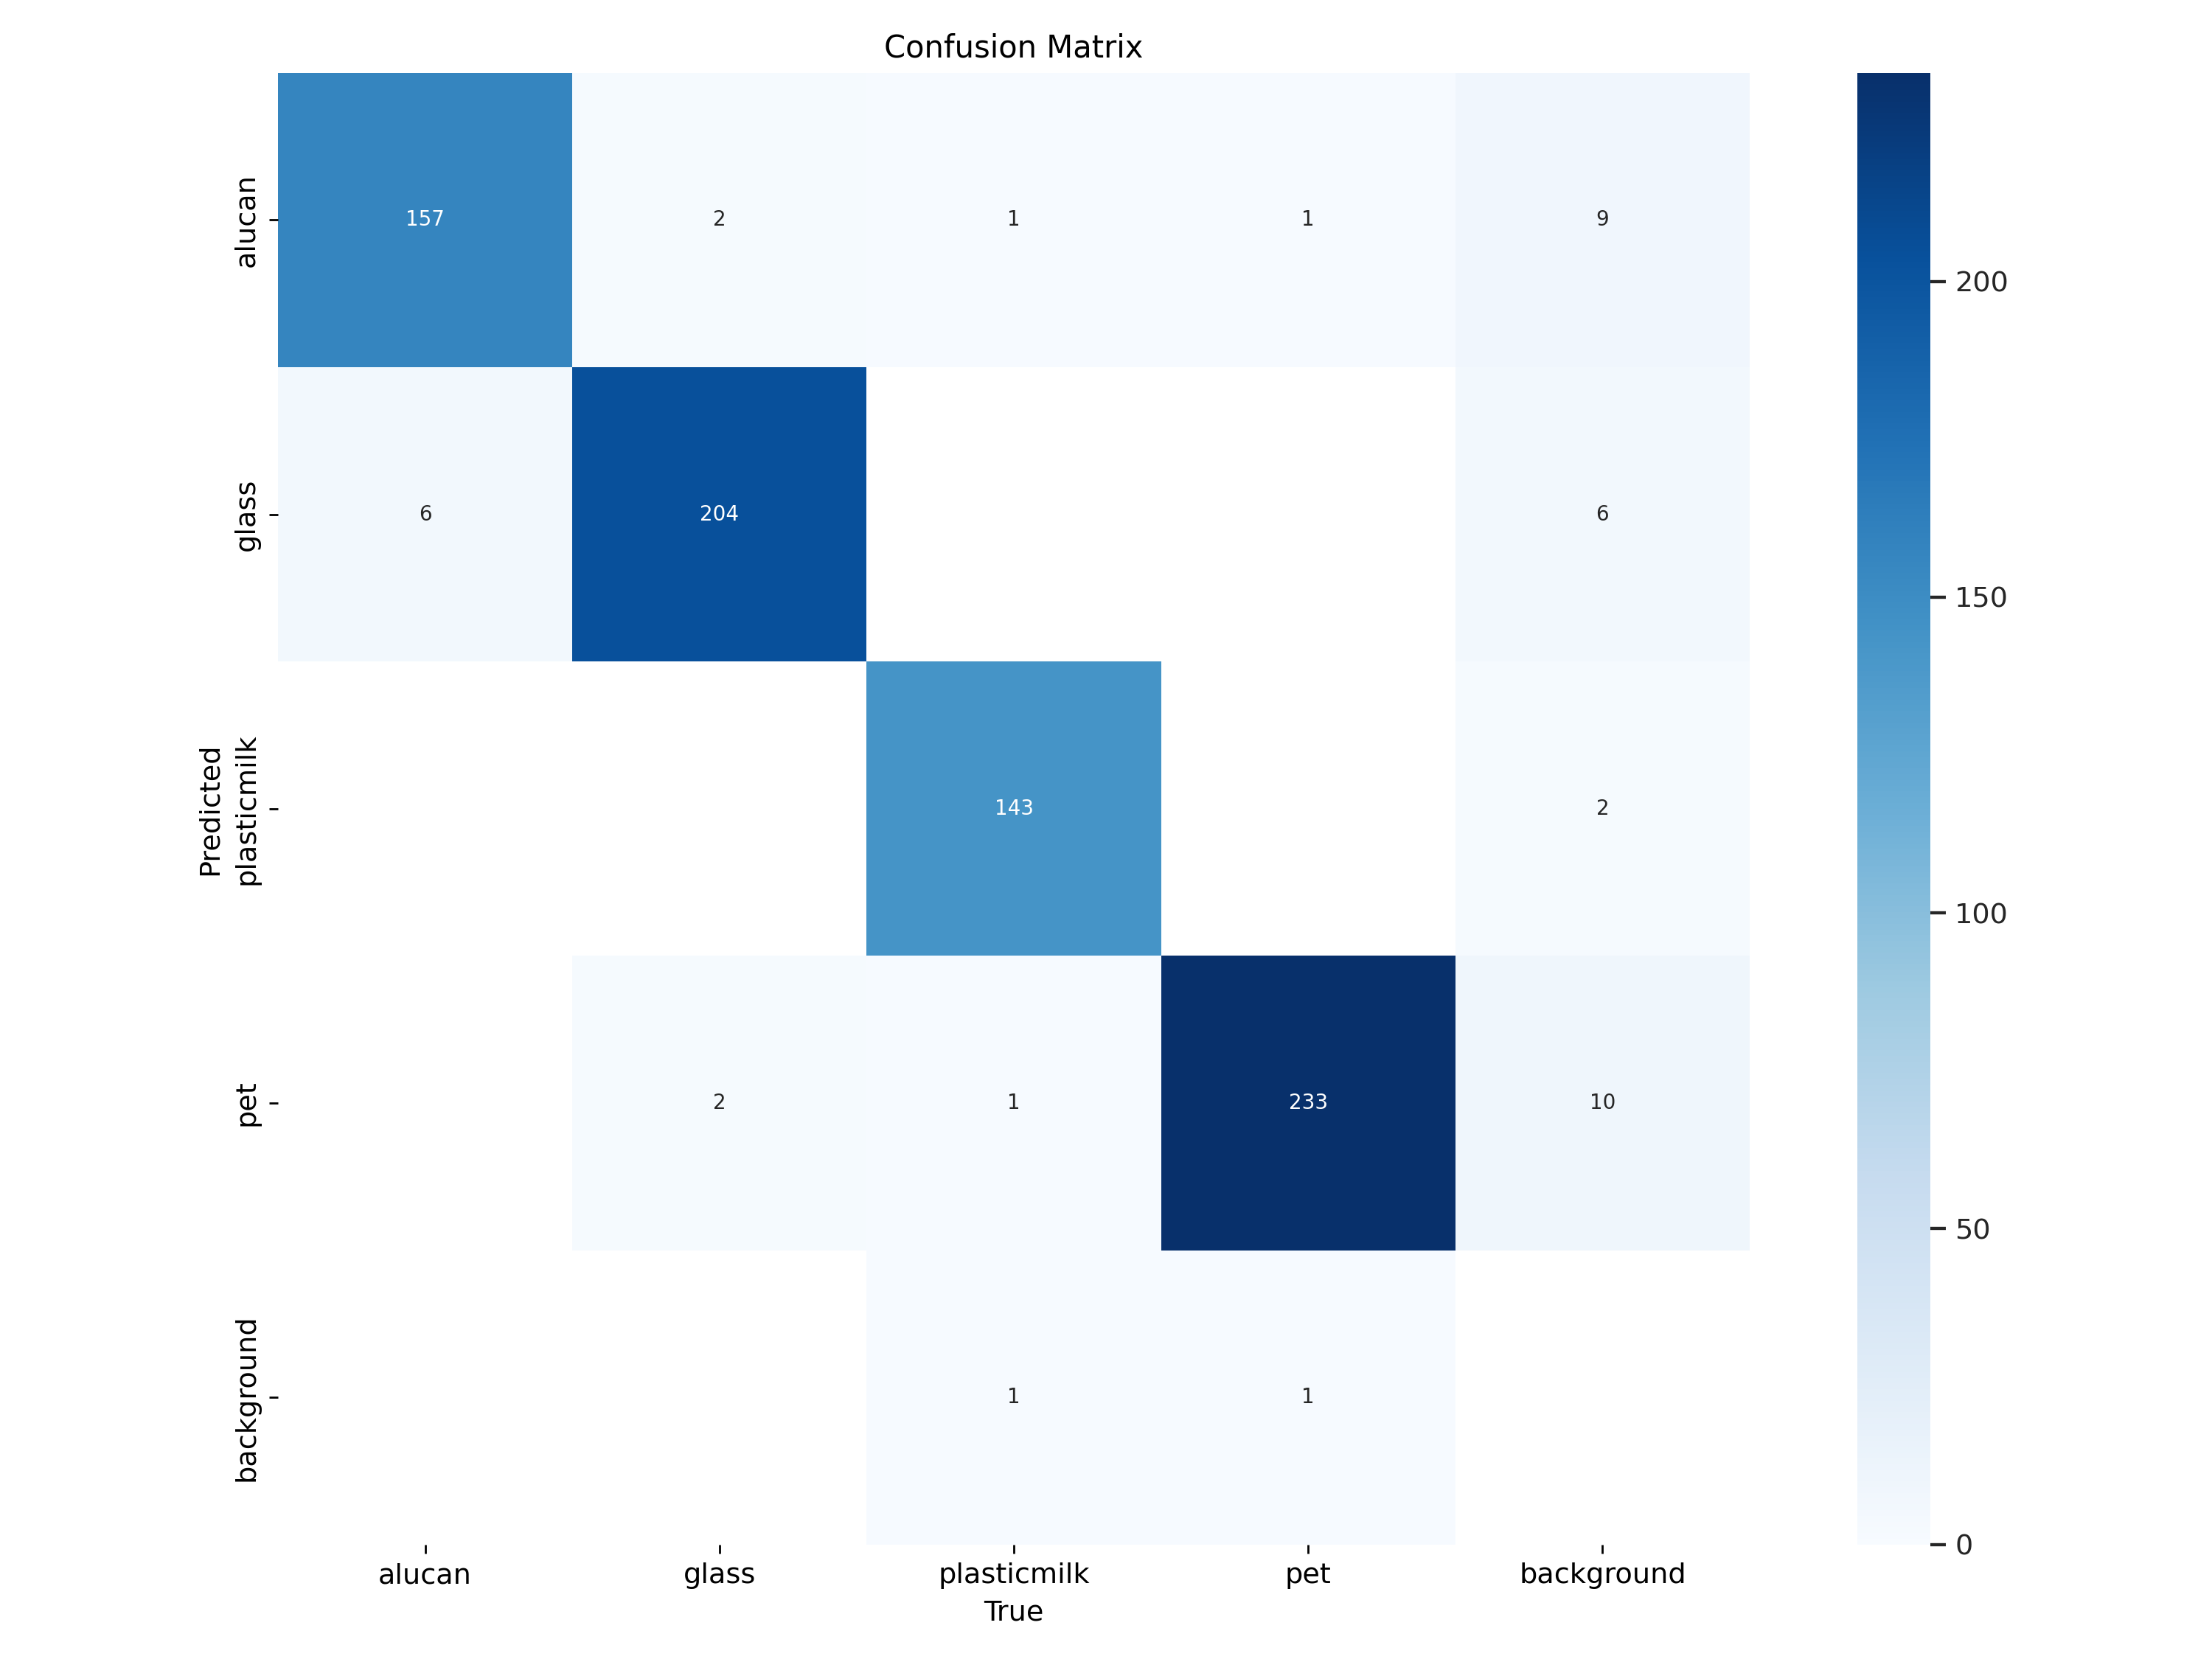

In [8]:
from IPython.display import Image, display
Image(filename=f"/content/runs/detect/train/confusion_matrix.png" , width=1800)

Outros paramêtros que nos ajudam a ter maior precisão do desempenho do modelo treinado são as métricas mAP50 e mAP50-95, que indicam a precisão do modelo no limiar de IoU ( Intersection of Union ou limiar de intersecção).

*   mAP50 - Precisão média calculada com um limiar de intersecção sobre união (IoU) de 0,50. É uma medida da precisão do modelo considerando apenas as detecções "fáceis".
*   mAP50-95 - A média da precisão média calculada em diferentes limiares de IoU, variando de 0,50 a 0,95. Dá uma visão abrangente do desempenho do modelo em diferentes níveis de dificuldade de deteção.



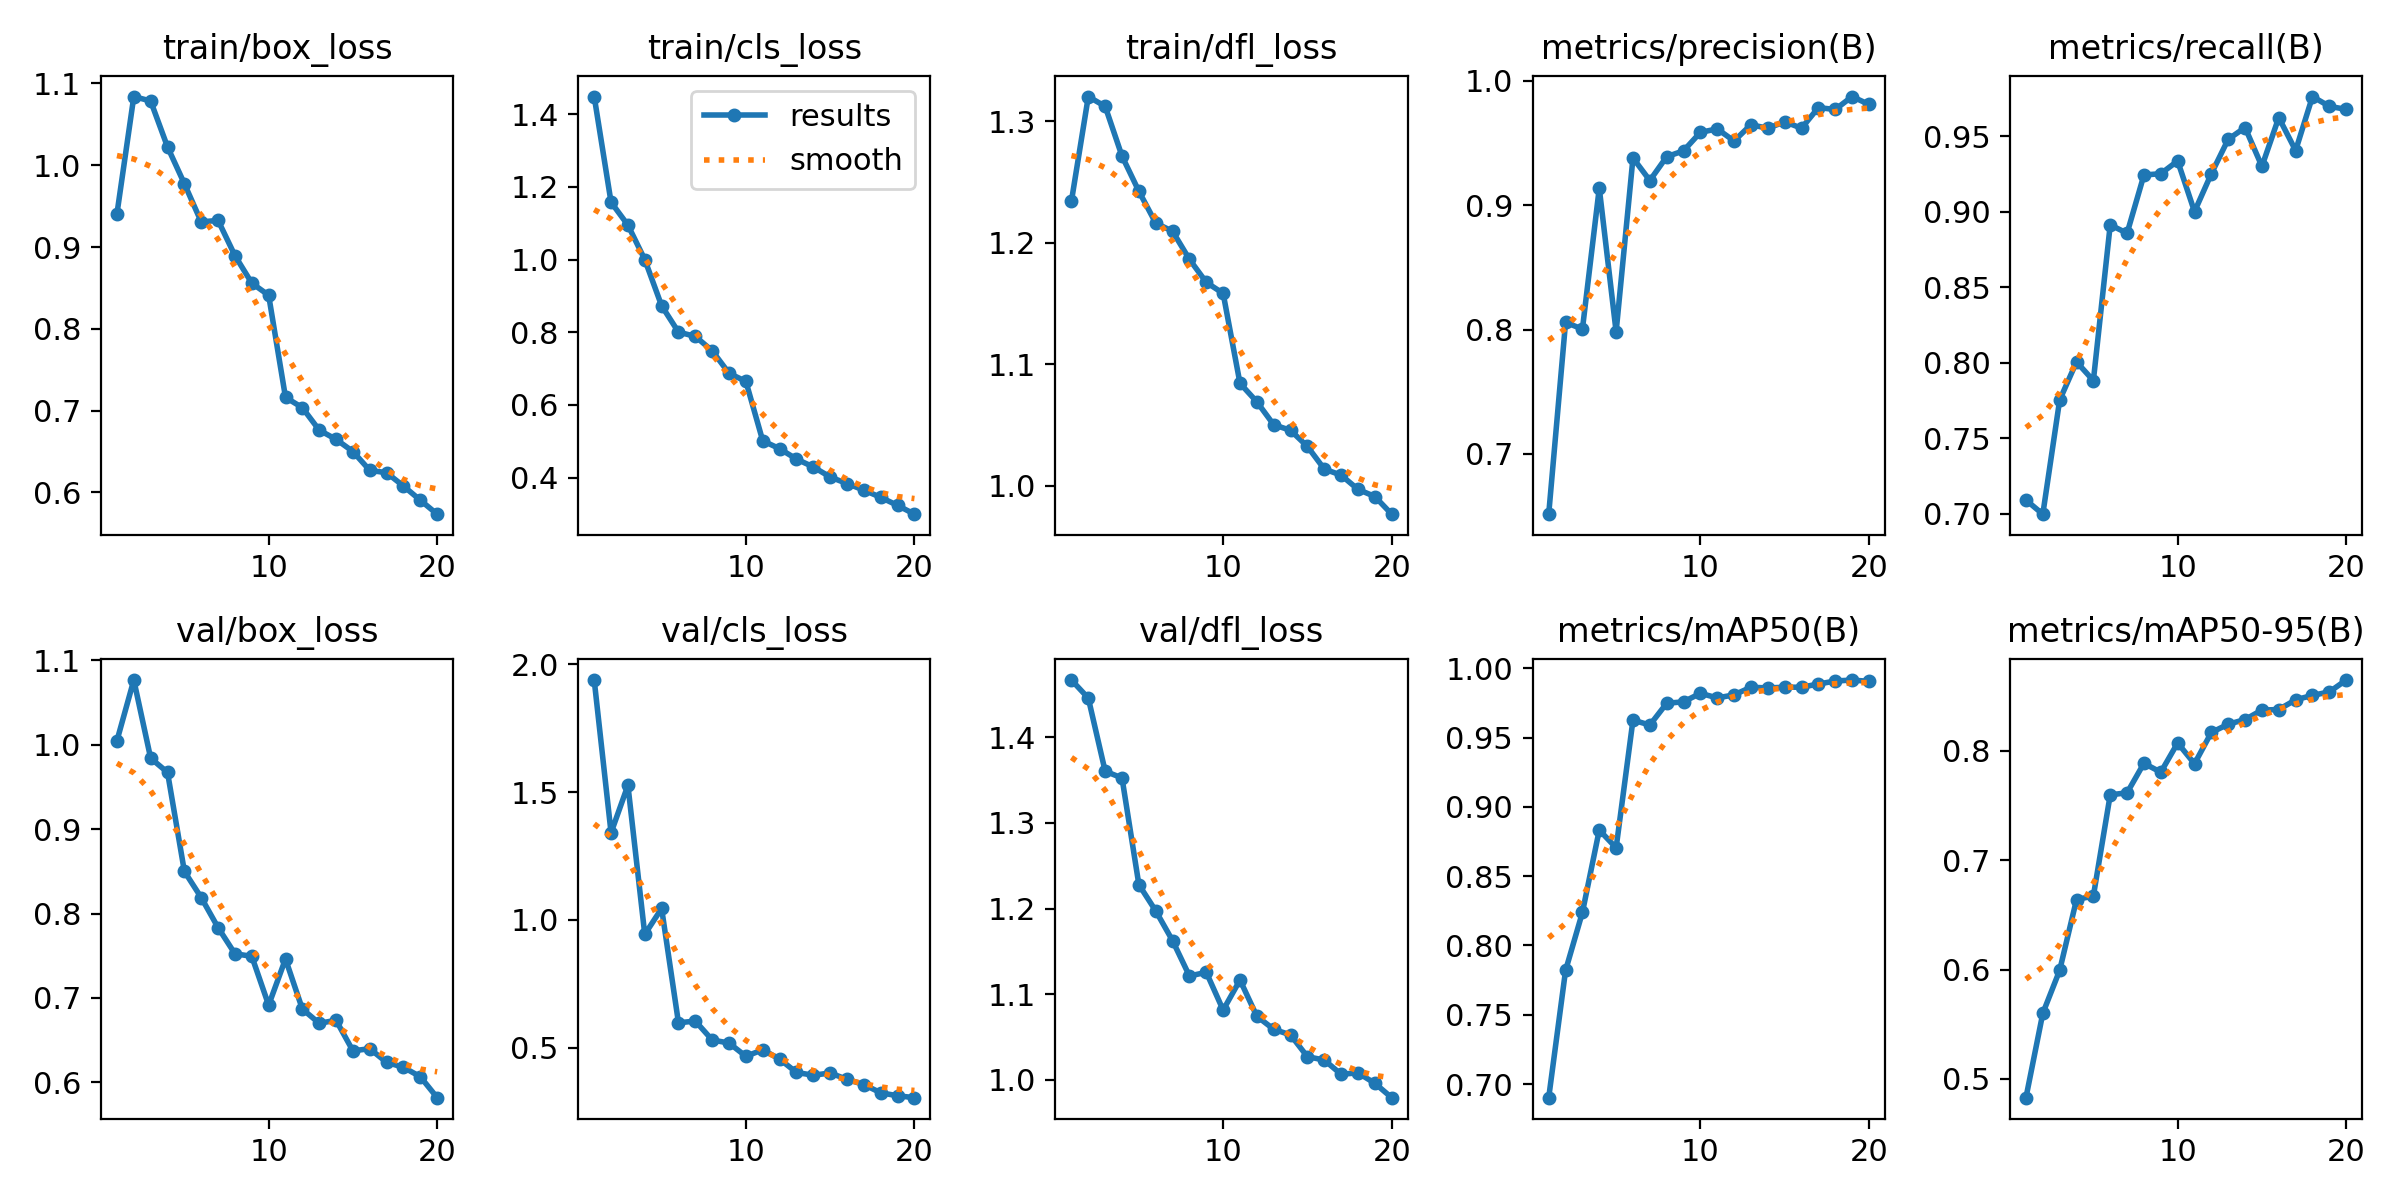

In [9]:
Image(filename=f"/content/runs/detect/train/results.png", width = 1800)

Podemos agora fazer a validação do nosso modelo com o trecho de código a seguir

In [10]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/waste-detection/data.yaml

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/waste-detection/val/labels.cache... 723 images, 0 backgrounds, 2 corrupt: 100% 723/723 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/waste-detection/val/images/HDPEM22.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0052]
val: WARNING ⚠️ /content/waste-detection/val/images/PET1,620.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 46/46 [00:15<00:00,  2.94it/s]
                   all        721        752      0.981      0.968      0.991      0.865
                alucan        158        163      0.975      0.951       0.99      0.788
                 glass        183        208      0.975       0.95      0.983      0.865
        

Passada a etapa de validação, podemos usar nosso dataset test para gerar as imagens e os bounding boxes com os nomes das classes para visualizar como nosso modelo está se comportando

In [11]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 source=/content/waste-detection/test/images

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs

image 1/722 /content/waste-detection/test/images/AluCan1,004.jpg: 640x480 1 alucan, 60.9ms
image 2/722 /content/waste-detection/test/images/AluCan1,010.jpg: 640x480 1 alucan, 27.7ms
image 3/722 /content/waste-detection/test/images/AluCan1,027.jpg: 640x480 1 alucan, 27.6ms
image 4/722 /content/waste-detection/test/images/AluCan1,028.jpg: 640x480 1 alucan, 27.6ms
image 5/722 /content/waste-detection/test/images/AluCan1,047.jpg: 640x480 1 alucan, 27.6ms
image 6/722 /content/waste-detection/test/images/AluCan1,057.jpg: 640x480 1 alucan, 27.6ms
image 7/722 /content/waste-detection/test/images/AluCan1,063.jpg: 640x480 1 alucan, 27.6ms
image 8/722 /content/waste-detection/test/images/AluCan102.jpg: 480x640 1 alucan, 47.9ms
image 9/722 /content/waste-detection/test/images/AluCan103.jpg: 480x640 1 alucan, 16.2ms
image 10/722 /conte

Para visualizar as imagens e suas predições podemos usar o comando a seguir

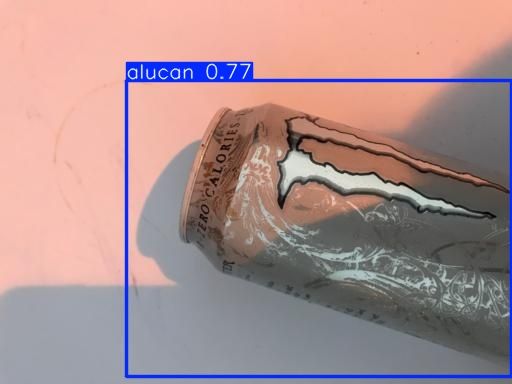

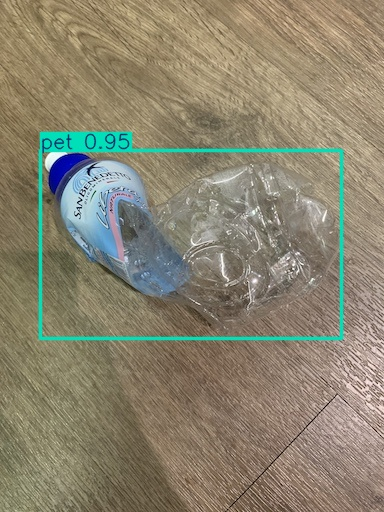

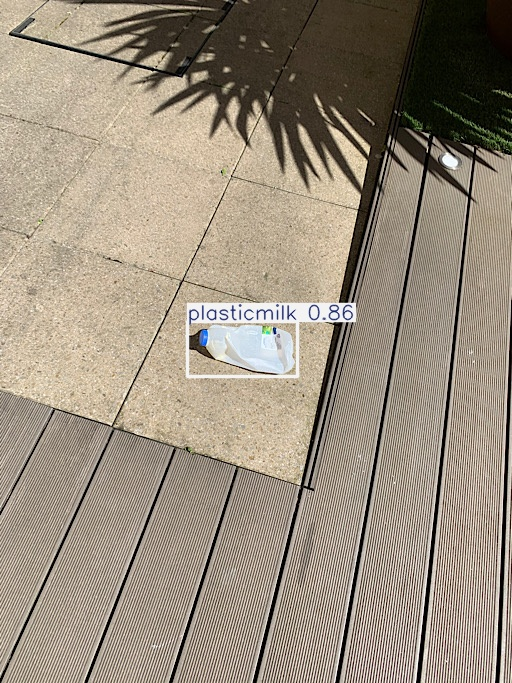

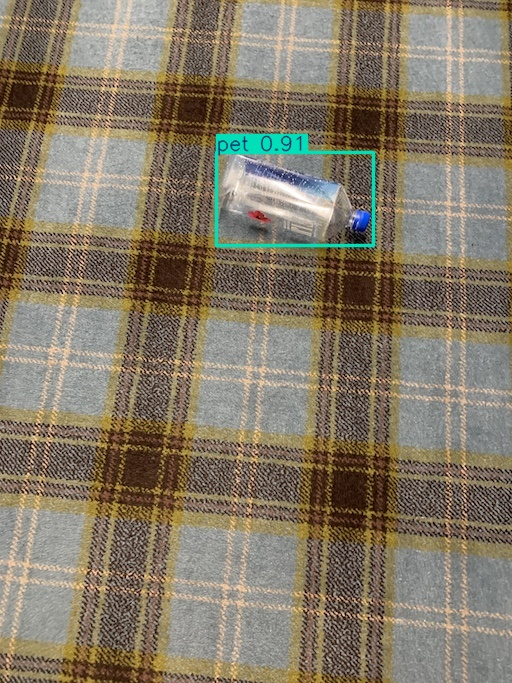

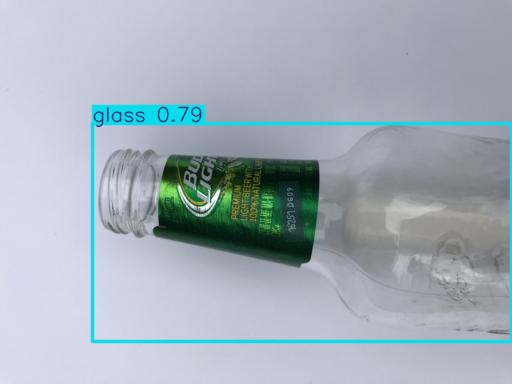

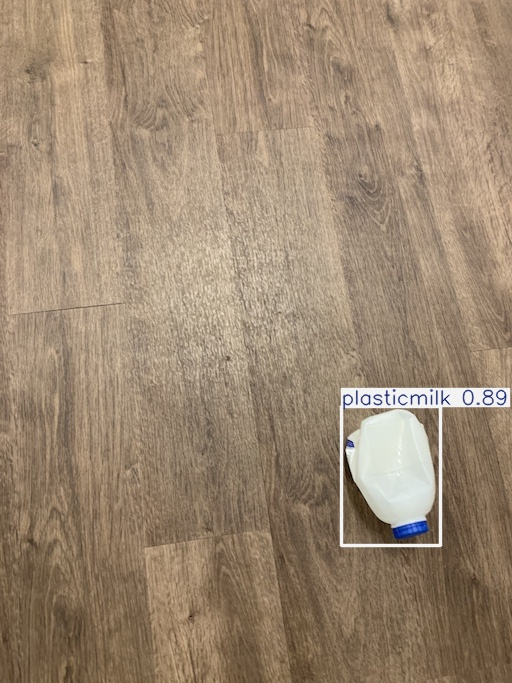

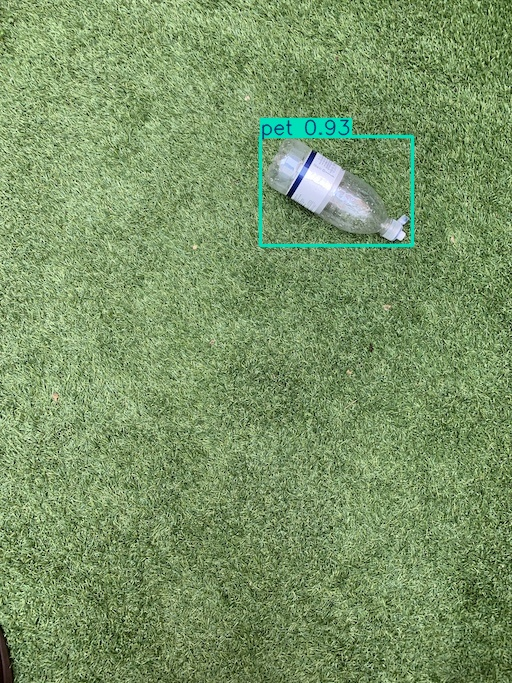

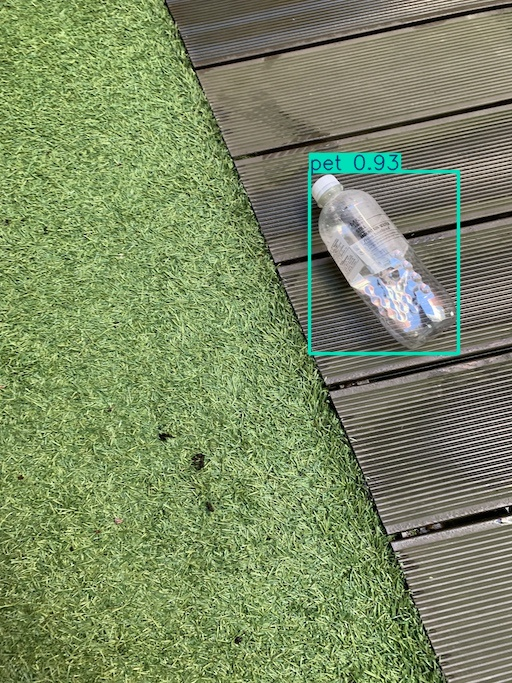

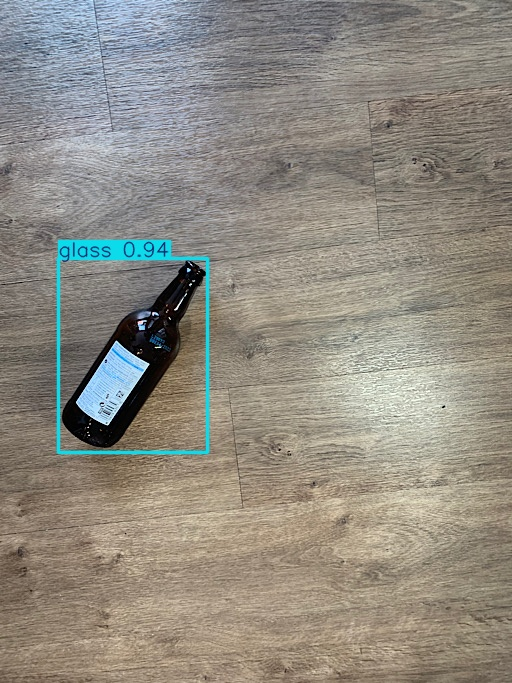

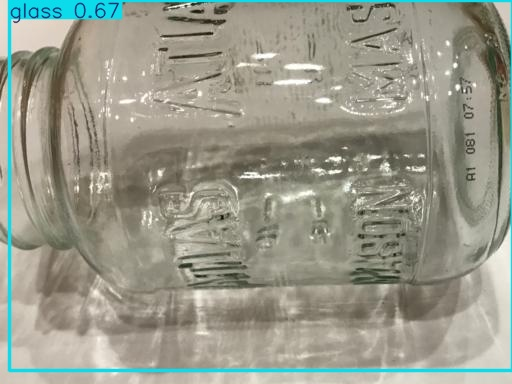

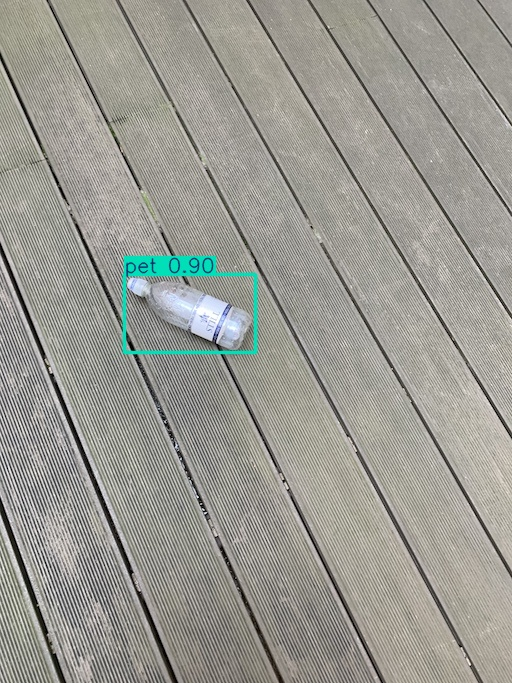

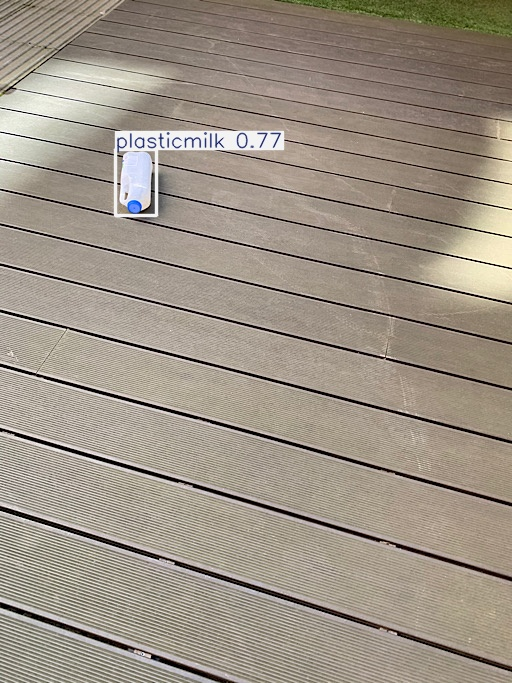

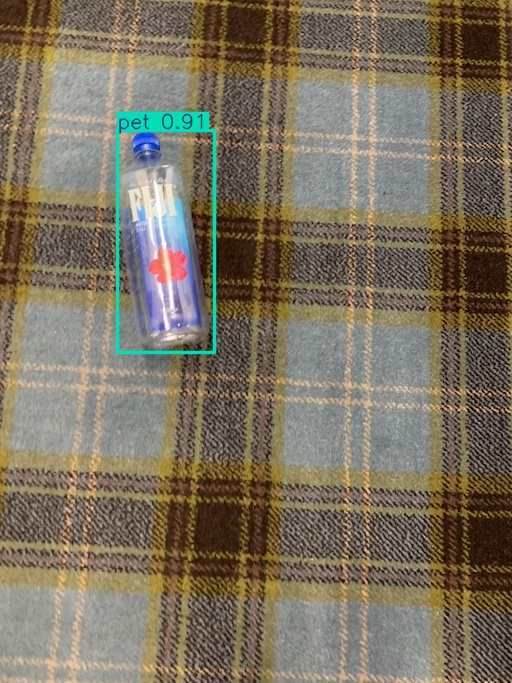

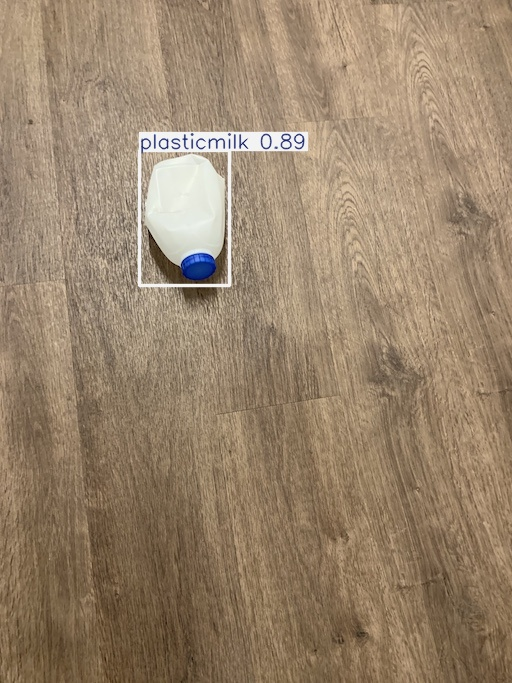

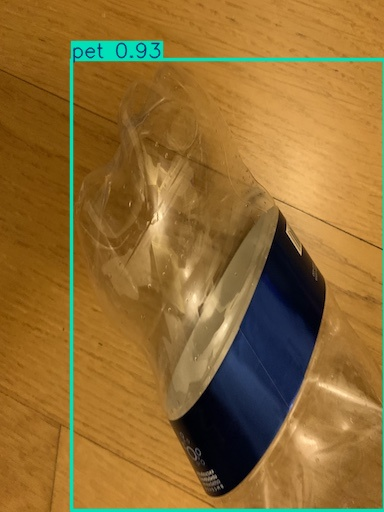

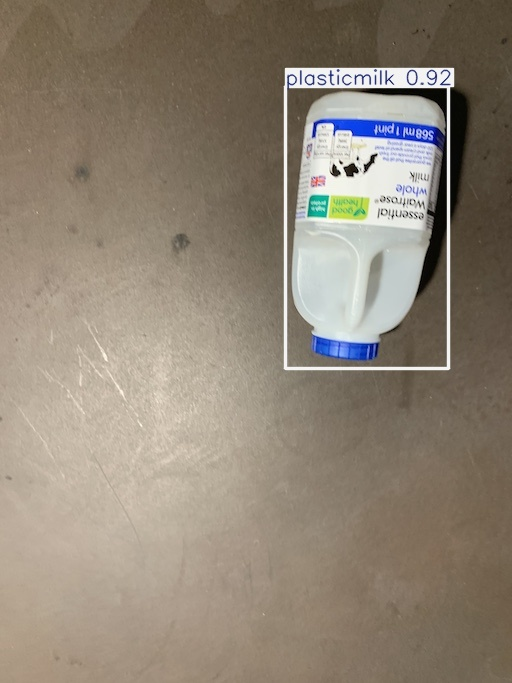

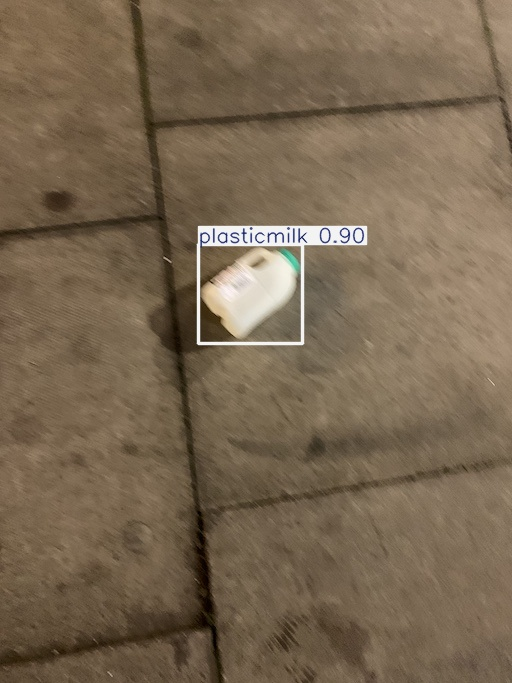

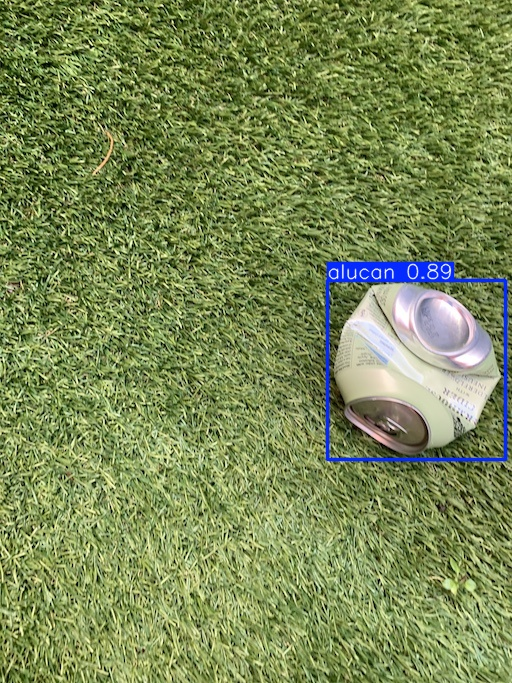

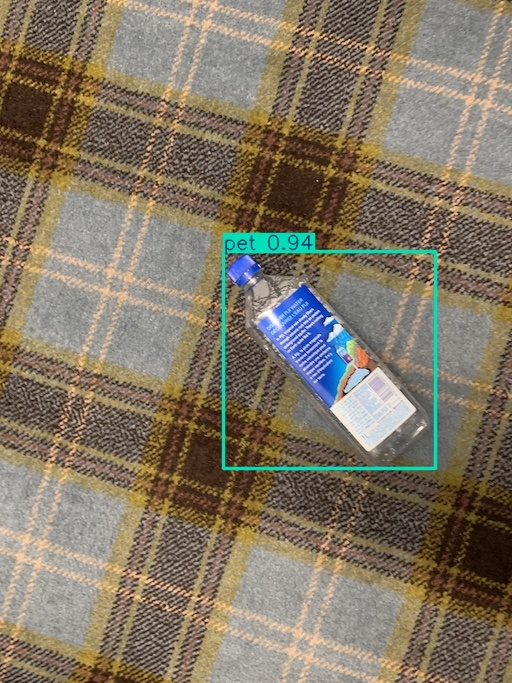

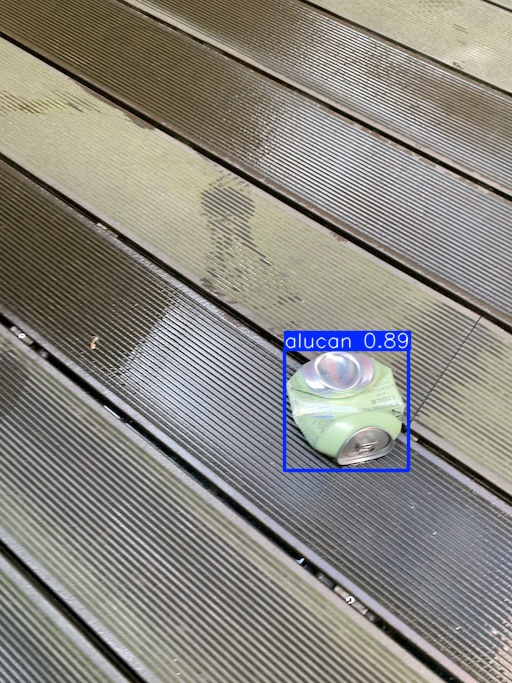

In [12]:
import glob
import random

image_paths = glob.glob('/content/runs/detect/predict/*.jpg')

random_image_paths = random.sample(image_paths, 20)

for image_path in random_image_paths:
    display(Image(filename=image_path, height=600))
    print('\n')